In [2]:
import sys
sys.path.append('../..')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from survival.utils import show_all

# Set style using the new style name
# Set style and context
plt.style.use('seaborn-v0_8-paper')
sns.set_context("paper", font_scale=1.1)

# Global rcParams
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'font.size': 11,
    'axes.titlesize': 13,
    'axes.labelsize': 11,
    'legend.frameon': False,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'lines.linewidth': 2,
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'Times', 'serif']
    
})


# Consistent colors
COLORS = ['#2E86C1', '#E74C3C', '#28B463', '#F39C12', '#8E44AD']
sns.set_palette(COLORS)

In [15]:
# load data
data = pd.read_parquet('../../data/processed/exploratory_data.parquet')
val = pd.read_parquet('../../data/processed/val_targets.parquet')


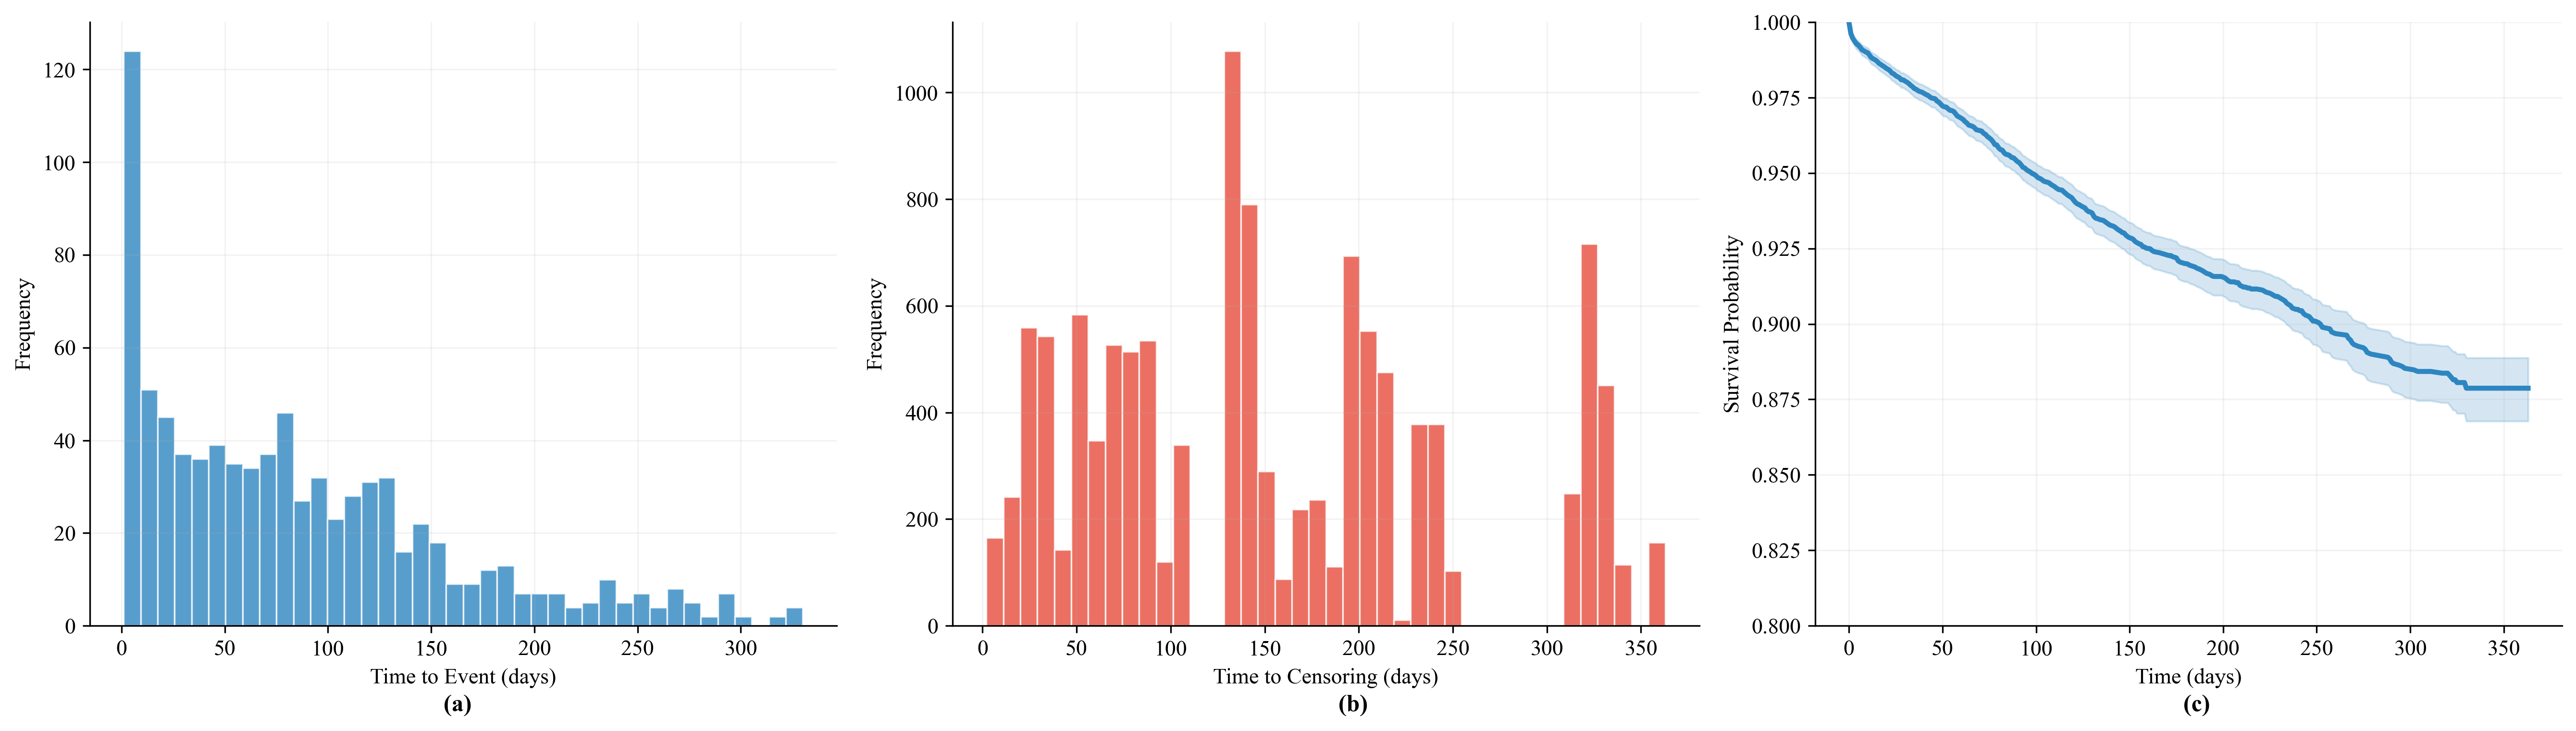

In [16]:
from lifelines import KaplanMeierFitter

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# 1. Event times histogram
event_times = val[val['event'] == 1]['time']
ax1.hist(event_times, bins=40, alpha=0.8, edgecolor='white', linewidth=0.8, color='#2E86C1')
ax1.set_xlabel('Time to Event (days)')
ax1.set_ylabel('Frequency')
ax1.grid(True, alpha=0.15)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# 2. Censoring distribution
censored_times = val[val['event'] == 0]['time']
ax2.hist(censored_times, bins=40, alpha=0.8, edgecolor='white', linewidth=0.8, color='#E74C3C')
ax2.set_xlabel('Time to Censoring (days)')
ax2.set_ylabel('Frequency')
ax2.grid(True, alpha=0.15)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# 3. Kaplan-Meier curve
kmf = KaplanMeierFitter()
kmf.fit(val['time'], val['event'])
ax3.plot(kmf.timeline, kmf.survival_function_, linewidth=2.5, color='#2E86C1')
ax3.fill_between(kmf.timeline, 
                kmf.confidence_interval_['KM_estimate_lower_0.95'],
                kmf.confidence_interval_['KM_estimate_upper_0.95'],
                alpha=0.2, color='#2E86C1')
ax3.set_xlabel('Time (days)')
ax3.set_ylabel('Survival Probability')
ax3.set_ylim(0.8, 1.0)
ax3.grid(True, alpha=0.15)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

fig.text(0.18, 0.001, '(a)', ha='center', fontsize=12, weight='bold')
fig.text(0.525, 0.001, '(b)', ha='center', fontsize=12, weight='bold') 
fig.text(0.85, 0.001, '(c)', ha='center', fontsize=12, weight='bold')


plt.tight_layout()
plt.show()

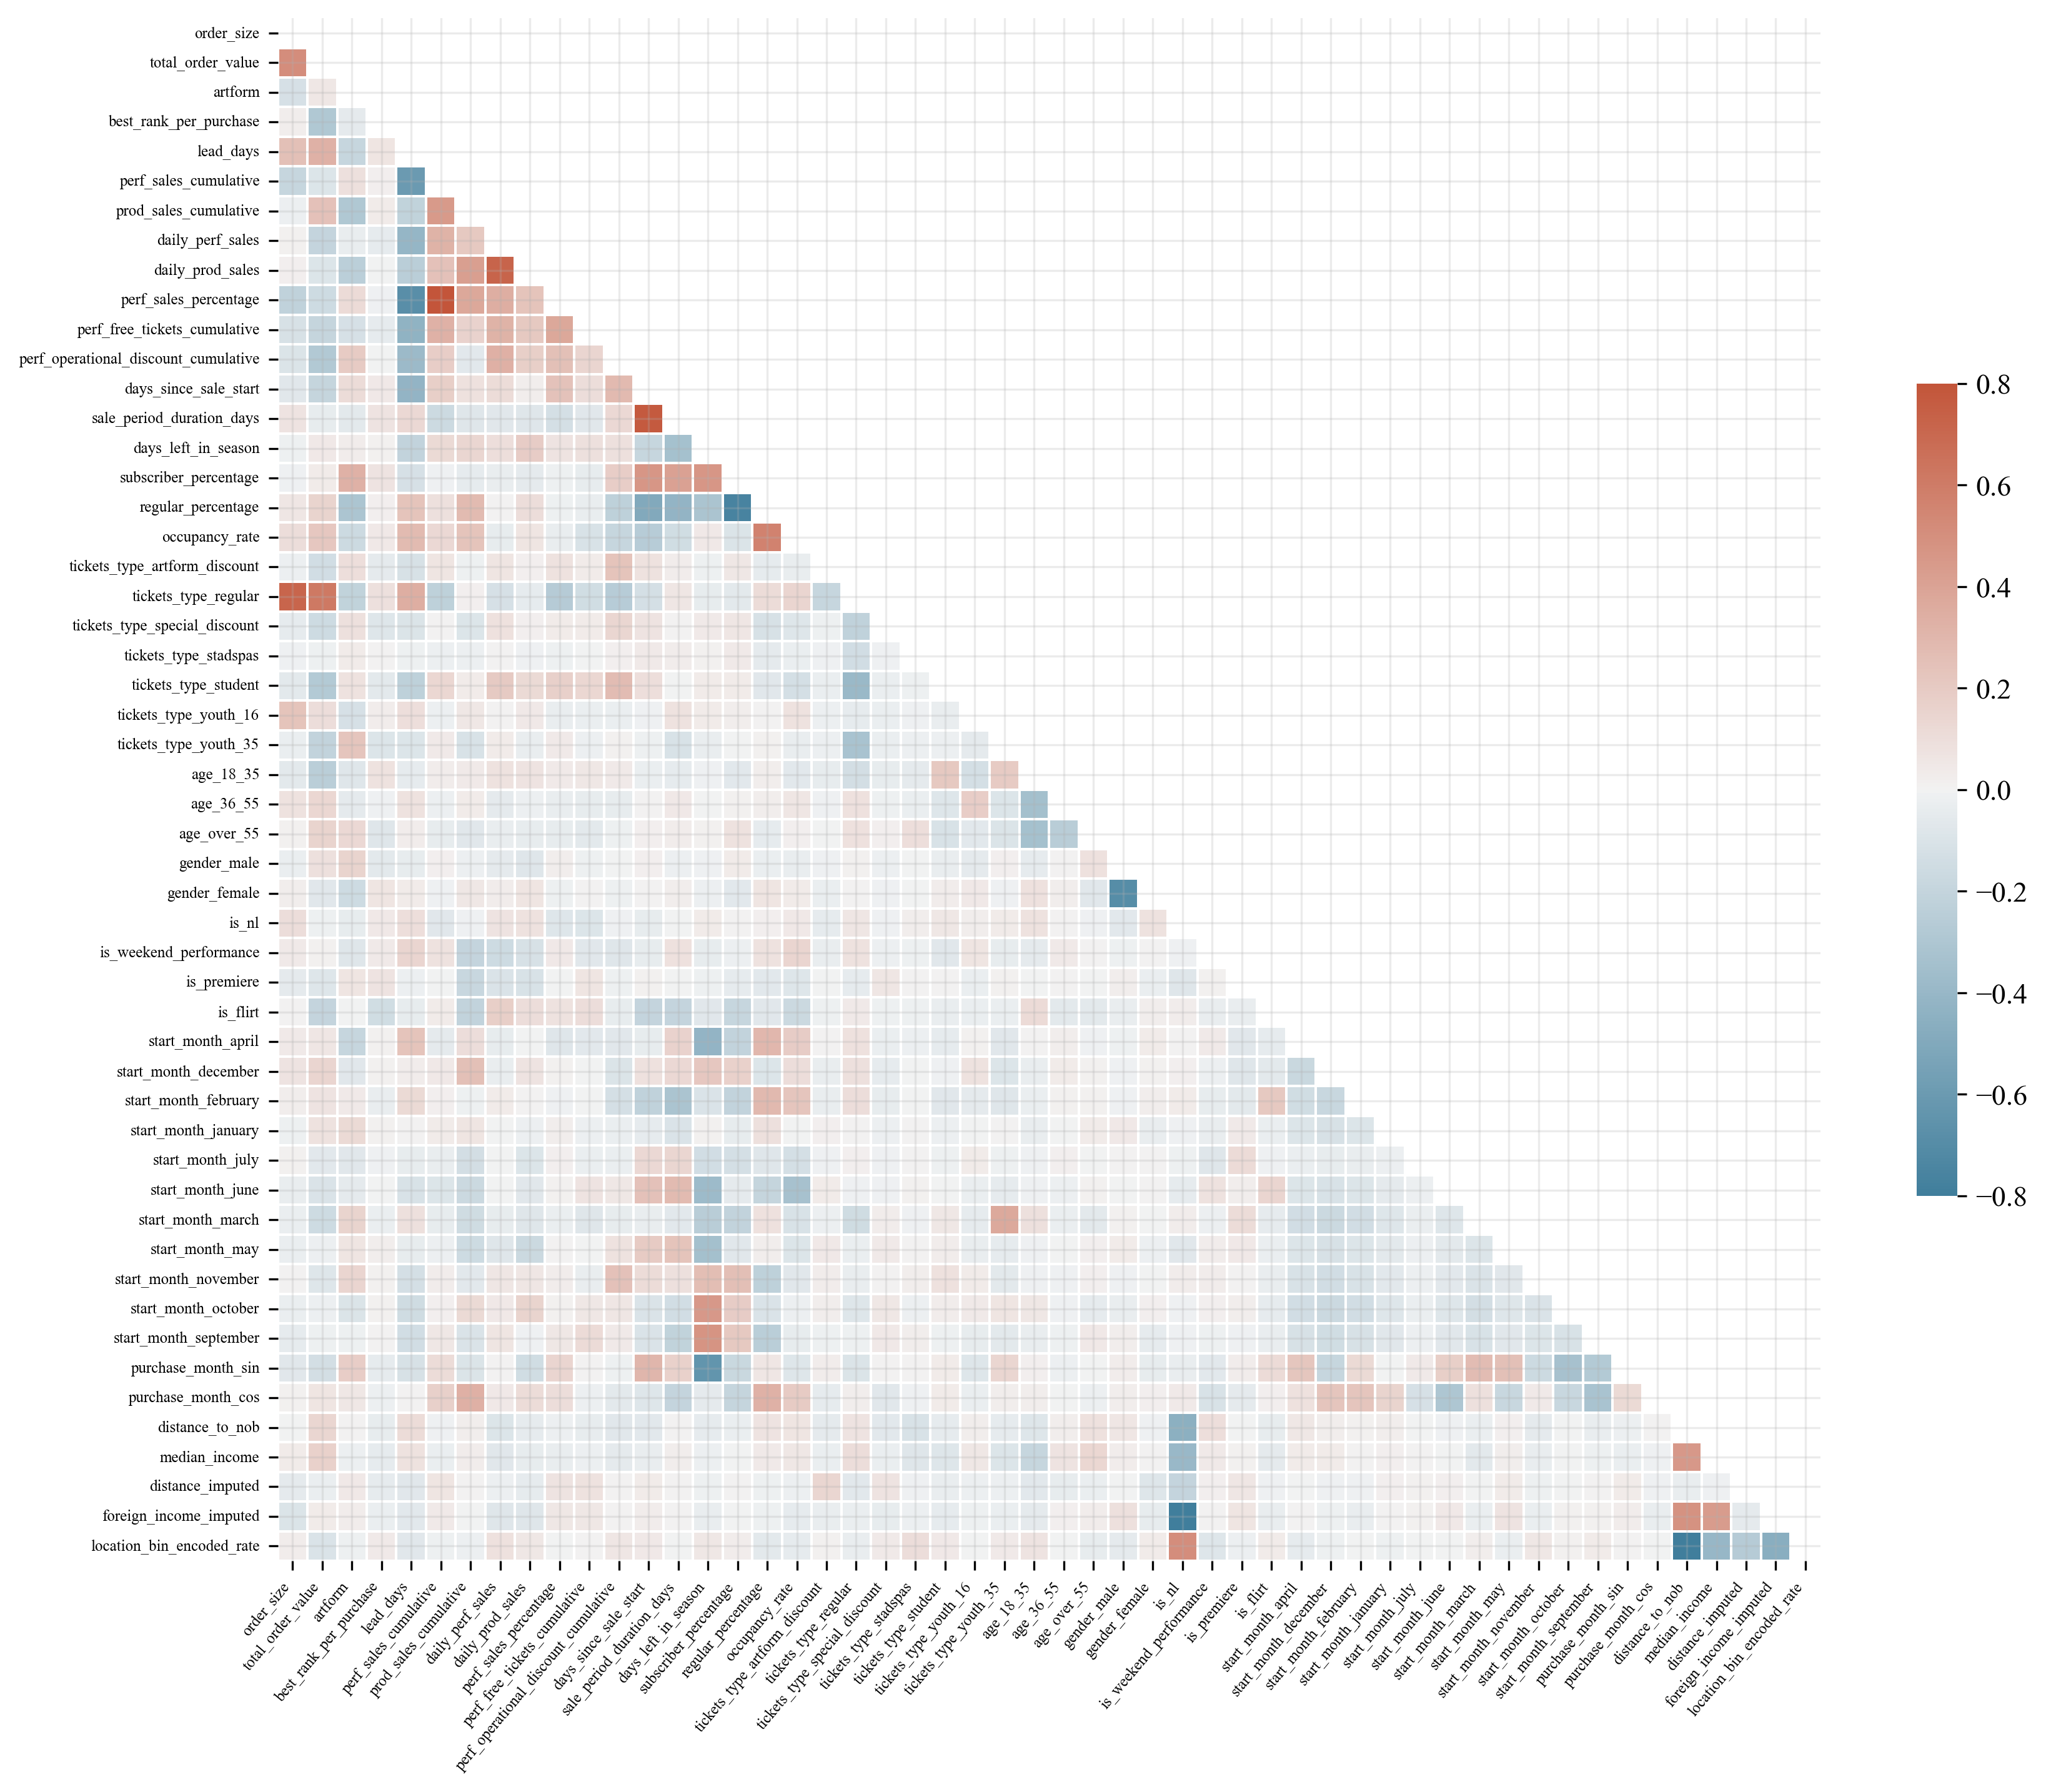

In [17]:
def plot_correlation_heatmap(df: pd.DataFrame):
   corr_matrix = df.corr(method='spearman')
   plt.rcParams['font.family'] = 'serif'
   plt.rcParams['font.serif'] = ['Times New Roman', 'Times', 'serif']
   
   mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
   fig, ax = plt.subplots(figsize=(12, 10))
   cmap = sns.diverging_palette(230, 20, as_cmap=True)
   
   sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.8, vmin=-.8,
               center=0, square=True, linewidths=.5, 
               cbar_kws={"shrink": .5}, annot=False, ax=ax)
   
   ax.set_xticks(np.arange(len(corr_matrix.columns)) + 0.5)
   ax.set_yticks(np.arange(len(corr_matrix.index)) + 0.5)
   ax.set_xticklabels(corr_matrix.columns, rotation=50, ha='right', fontsize=6)
   ax.set_yticklabels(corr_matrix.index, rotation=0, fontsize=6)
   
   ax.spines['top'].set_visible(False)
   ax.spines['right'].set_visible(False)
   ax.spines['bottom'].set_visible(False)
   ax.spines['left'].set_visible(False)
   
   plt.grid(True, alpha=0.25)
   plt.tight_layout()
   plt.show()

plot_correlation_heatmap(data.drop(['time', 'event'], axis=1))

In [14]:
corr_matrix = data.corr(method='spearman')
high_corr = corr_matrix[abs(corr_matrix) > 0.7]
high_corr = high_corr.stack().reset_index()
high_corr.columns = ['Variable 1', 'Variable 2', 'Correlation']
high_corr = high_corr[high_corr['Variable 1'] != high_corr['Variable 2']]

# Remove duplicate pairs by keeping only one direction
high_corr = high_corr[high_corr['Variable 1'] < high_corr['Variable 2']]

high_corr = high_corr.sort_values('Correlation', key=abs, ascending=False)
high_corr

,Variable 1,Variable 2,Correlation
7,perf_sales_cumulative,perf_sales_percentage,0.968945
62,foreign_income_imputed,is_nl,-0.913358
59,distance_to_nob,location_bin_encoded_rate,-0.870427
18,days_since_sale_start,sale_period_duration_days,0.770114
24,regular_percentage,subscriber_percentage,-0.757196
10,daily_perf_sales,daily_prod_sales,0.724342
1,order_size,tickets_type_regular,0.713717
